Epoch 1/100:
  Average Loss: 1.4437
  Lipschitz Bound: 2.1623
  Layer Spectral Norms: ['1.6942', '2.0253', '0.9370']
Epoch 2/100:
  Average Loss: 0.1052
  Lipschitz Bound: 2.2834
  Layer Spectral Norms: ['1.9819', '1.1627', '0.9535']
Epoch 3/100:
  Average Loss: 0.0659
  Lipschitz Bound: 2.8482
  Layer Spectral Norms: ['1.9695', '1.7083', '0.9572']
Epoch 4/100:
  Average Loss: 0.0612
  Lipschitz Bound: 3.6582
  Layer Spectral Norms: ['1.5575', '1.7379', '0.9545']
Epoch 5/100:
  Average Loss: 0.0590
  Lipschitz Bound: 1.8643
  Layer Spectral Norms: ['1.7062', '2.3973', '0.9526']
Epoch 6/100:
  Average Loss: 0.0601
  Lipschitz Bound: 3.1643
  Layer Spectral Norms: ['2.1982', '1.3928', '0.9488']
Epoch 7/100:
  Average Loss: 0.0592
  Lipschitz Bound: 4.1295
  Layer Spectral Norms: ['1.5352', '1.6346', '0.9488']
Epoch 8/100:
  Average Loss: 0.0566
  Lipschitz Bound: 1.8736
  Layer Spectral Norms: ['1.2790', '1.6359', '0.9427']
Epoch 9/100:
  Average Loss: 0.0562
  Lipschitz Bound: 2.6966
  

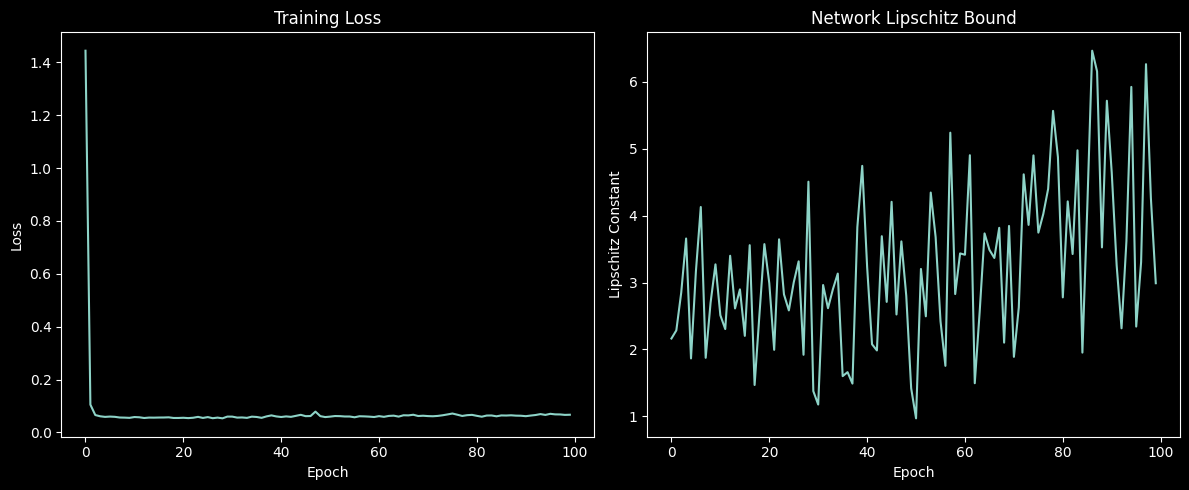

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class SpectralNormCalculator:
    """Helper class to calculate and track spectral norms during training"""
    def __init__(self, n_power_iterations=1):
        self.n_power_iterations = n_power_iterations
    
    def calculate_spectral_norm(self, weight_matrix):
        """
        Calculate spectral norm using power iteration method
        
        Args:
            weight_matrix (torch.Tensor): Weight matrix of shape (out_features, in_features)
            
        Returns:
            float: Spectral norm of the matrix
        """
        if len(weight_matrix.shape) > 2:
            # For conv layers, reshape to matrix
            weight_matrix = weight_matrix.reshape(weight_matrix.shape[0], -1)
            
        # Initialize random vector
        u = torch.randn(weight_matrix.shape[0], 1, device=weight_matrix.device)
        u = u / torch.norm(u)
        
        # Power iteration
        with torch.no_grad():
            for _ in range(self.n_power_iterations):
                # v ← W^T u
                v = torch.matmul(weight_matrix.t(), u)
                v = v / torch.norm(v)
                
                # u ← W v
                u = torch.matmul(weight_matrix, v)
                u = u / torch.norm(u)
        
        # Spectral norm is approximately u^T W v
        spectral_norm = torch.matmul(torch.matmul(u.t(), weight_matrix), v)
        return spectral_norm.item()

class SpectralNormRegularizedNet(nn.Module):
    """Neural network with spectral norm regularization"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        
        self.spectral_calculator = SpectralNormCalculator()
        self.spectral_norms = []
    
    def forward(self, x):
        # Forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def calculate_layer_spectral_norms(self):
        """Calculate spectral norms for all layers"""
        norms = []
        for layer in [self.fc1, self.fc2, self.fc3]:
            norm = self.spectral_calculator.calculate_spectral_norm(layer.weight)
            norms.append(norm)
        return norms
    
    def get_lipschitz_bound(self):
        """Calculate upper bound on the Lipschitz constant"""
        norms = self.calculate_layer_spectral_norms()
        return np.prod(norms)

def train_with_spectral_regularization(model, train_loader, epochs=10, lr=0.01, spectral_weight=0.01):
    """
    Train the model with spectral norm regularization
    
    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        epochs: Number of training epochs
        lr: Learning rate
        spectral_weight: Weight for spectral norm regularization
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    
    training_losses = []
    lipschitz_constants = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_x)
            
            # Calculate main loss
            main_loss = criterion(outputs, batch_y)
            
            # Calculate spectral norm regularization
            spectral_norms = model.calculate_layer_spectral_norms()
            spectral_reg = sum(norms for norms in spectral_norms)
            
            # Total loss with regularization
            loss = main_loss + spectral_weight * spectral_reg
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        # Track metrics
        avg_epoch_loss = epoch_loss / len(train_loader)
        lipschitz_constant = model.get_lipschitz_bound()
        
        training_losses.append(avg_epoch_loss)
        lipschitz_constants.append(lipschitz_constant)
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Average Loss: {avg_epoch_loss:.4f}')
        print(f'  Lipschitz Bound: {lipschitz_constant:.4f}')
        print(f'  Layer Spectral Norms: {[f"{norm:.4f}" for norm in spectral_norms]}')
    
    return training_losses, lipschitz_constants

# Example usage with synthetic data
def generate_synthetic_data(n_samples=1000):
    """Generate synthetic regression data"""
    
    X = torch.randn(n_samples, 5)  # 5 input features
    w = torch.randn(5, 1)
    y = torch.matmul(X, w) + 0.1 * torch.randn(n_samples, 1)
    return X, y

# Create dataset and model
X, y = generate_synthetic_data()
train_loader = DataLoader(list(zip(X, y)), batch_size=32, shuffle=True)

# Initialize model
model = SpectralNormRegularizedNet(input_dim=5, hidden_dim=32, output_dim=1)

# Train model
losses, lipschitz_bounds = train_with_spectral_regularization(
    model, 
    train_loader,
    epochs=100,
    spectral_weight=0.01
)

# Plot training progression
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(lipschitz_bounds)
plt.title('Network Lipschitz Bound')
plt.xlabel('Epoch')
plt.ylabel('Lipschitz Constant')

plt.tight_layout()
plt.show()